### Importing the necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as pil
import skimage as im
import amglib.readers as io
from skimage.filters import threshold_otsu
from skimage.segmentation import watershed
from skimage.morphology import binary_erosion as erode
from skimage.morphology import binary_dilation as dilate
from skimage.morphology import disk
from skimage.morphology import h_maxima
import skimage.morphology.greyreconstruct as gr
from skimage.morphology import label
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import matplotlib.colors as colors
from skimage.color      import hsv2rgb, rgb2hsv
from matplotlib.colors import ListedColormap
from tqdm.notebook import tqdm
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse

%matplotlib inline
#%matplotlib widget

import importlib
importlib.reload(io)

<module 'amglib.readers' from 'C:\\Users\\Asus\\OneDrive - National University of Singapore\\Study\\ETH Zurich\\Quantitative Big Imaging\\scripts-master\\python\\amglib\\readers.py'>

### Importing Datapath where the images are stored

In [2]:
datapath = 'C:/Users/Asus/OneDrive - National University of Singapore/Study/ETH Zurich/Quantitative Big Imaging/P20221368/02_rawdata/03_Beads_2.37x/'
datapath1 = 'C:/Users/Asus/OneDrive - National University of Singapore/Study/ETH Zurich/Quantitative Big Imaging/P20221368/02_rawdata/04_Beads_4.14x/' 

In [3]:
dc=io.read_images(datapath+'dc_{:05}.fits',first=1,last=10,averageStack=True,average='mean');
ob=io.read_images(datapath+'ob_{:05}.fits',first=1,last=10,averageStack=True,average='mean');
cal=io.read_images(datapath+'beads_{:05}.fits',first=21,last=360,stride=10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

### Normalize

In [4]:
ob1=ob-dc
np.nan_to_num(ob1)
ob1[ob1<=0]=1
print(dc.min(),dc.max(),dc.mean())
print(ob1.min(),ob1.max(),ob1.mean())

0.0 65535.0 3115.293
1.0 37828.3 28576.568


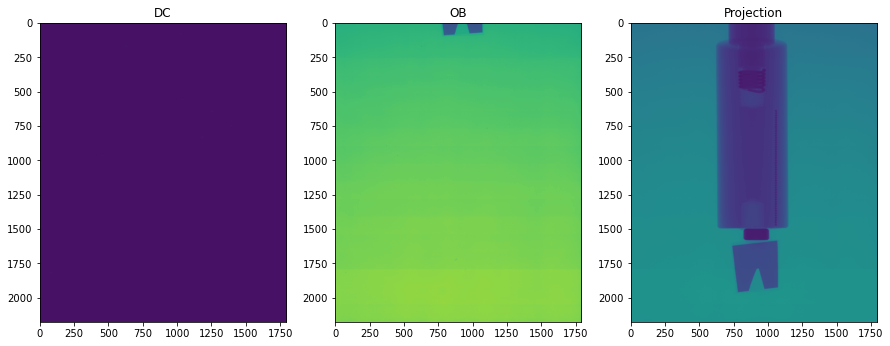

In [5]:
fig, ax = plt.subplots(1,3,figsize=(15,7))
ax=ax.ravel()
ax[0].imshow(dc)
ax[0].set_title('DC')
ax[1].imshow(ob1)
ax[1].set_title('OB')
ax[2].imshow(cal[1,:,:]) #,vmin=0.0,vmax=10000)
ax[2].set_title('Projection');

In [6]:
def normalizeData(img,ob,dc) :
    for idx in np.arange(0, img.shape[0]):
        tmp=(img[idx,:,:]-dc)
        tmp[tmp<=0]=1
        img[idx,:,:]=(tmp/ob)
    lcal=-np.log(img)
    
    return lcal

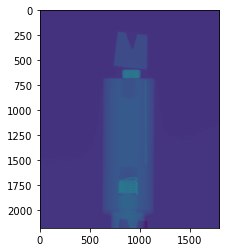

In [7]:
lcal=normalizeData(cal,ob1,dc)
flipProjection = True
if flipProjection : 
    lcal = lcal[:,::-1,:]
    
plt.imshow(lcal[1,:,:])

### Removing unwanted elements from the image - optional depending on how much extra background is captured

In [8]:
new_lcal=lcal
for i in range(lcal.shape[0]):
    for j in range(lcal.shape[2]):
        for k in range(800):
            new_lcal[i,k,j]=lcal[i,1250,200]
        for k in range(1600,2176):
            new_lcal[i,k,j]=lcal[i,1250,200]

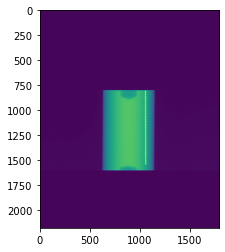

In [9]:
plt.imshow(new_lcal[1,:,:])

In [10]:
lcal=new_lcal

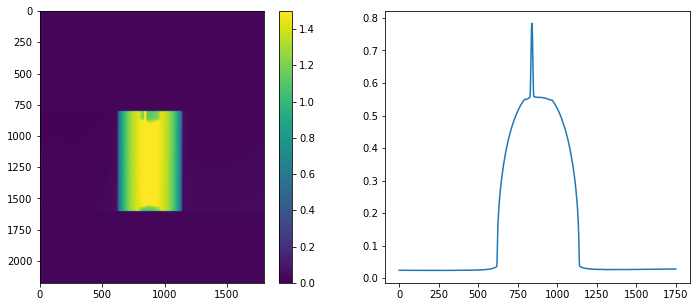

In [11]:
idx=10
plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
plt.imshow(lcal[idx,:,:],vmin=0,vmax=1.5)
plt.colorbar()
plt.subplot(1,2,2)
plt.plot(lcal[idx,:,:].mean(axis=0)[:1750])

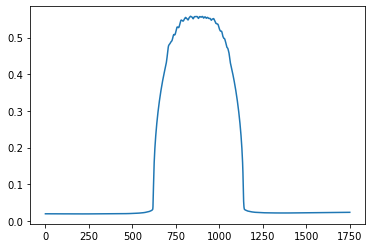

In [12]:
baseline = lcal.mean(axis=0).mean(axis=0)
baseline = baseline.reshape(1,baseline.shape[0])
plt.plot(baseline.ravel()[:1750])

In [13]:
print(lcal.shape)

(34, 2176, 1792)


### Removing Baseline

In [14]:
def removeBaseline(img) :
    img=img[:,:,0:1750]
    baseline = img.mean(axis=0).mean(axis=0)
    baseline = baseline.reshape(1,baseline.shape[0])

    b2=np.matmul(np.ones([img.shape[1],1]),baseline)
    res=img;
    print(b2.shape,res.shape)
    for idx in np.arange(0,img.shape[0]) :
        res[idx,:,:]=res[idx,:,:]-b2
    return res

bcal=removeBaseline(lcal)

(2176, 1750) (34, 2176, 1750)


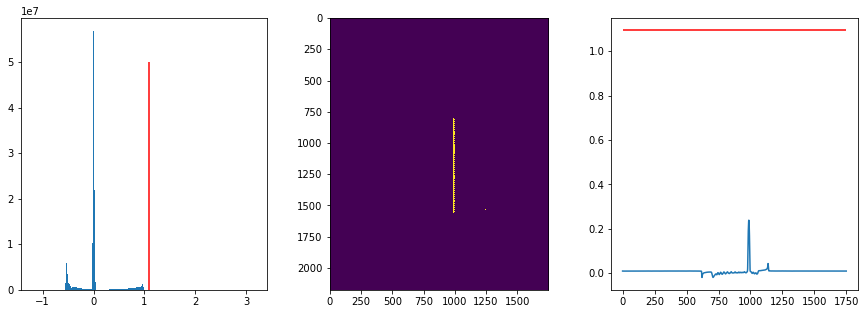

In [15]:
idx=5
m = bcal.mean()
s = bcal.std()
k=3.3
fig,ax=plt.subplots(1,3,figsize=[15,5])
ax[0].hist(bcal.ravel(),bins=256)
ax[0].vlines(m+k*s,ymin=0,ymax=5e7,color='r')
im=ax[1].imshow(m+k*s < bcal[idx,:,:],interpolation='None')
ax[2].plot(bcal[idx,:,:].mean(axis=0));
ax[2].hlines(m+k*s,xmin=0, xmax=bcal.shape[2],color='r');

In [16]:
def thresholdBBs(img,k) :
    s=bcal.std()
    m=bcal.mean()
    
    return (m+k*s)< img

tcal=thresholdBBs(bcal,3.3)

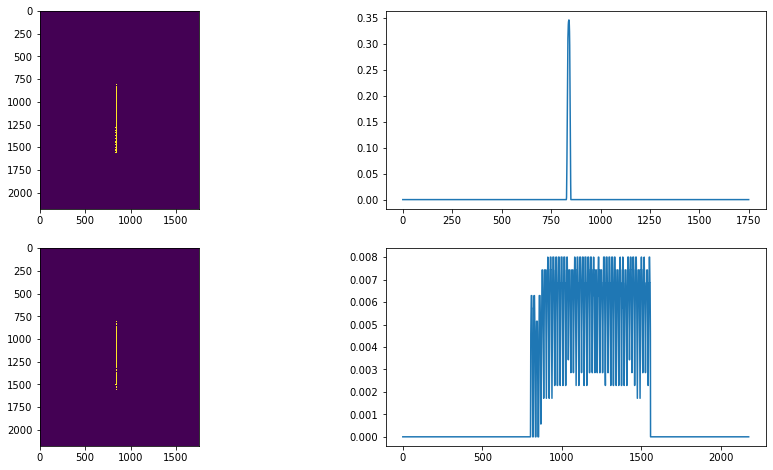

In [17]:
from skimage.transform import rescale, resize, downscale_local_mean
idx=10
fig,ax = plt.subplots(2,2,figsize=(15,8))
ax=ax.ravel()
ax[0].imshow(tcal[idx,:,:],interpolation='None')
ax[1].plot(tcal[idx,:,:].mean(axis=0))
ecal = erode(tcal[idx,:,:],disk(2))
ax[2].imshow(ecal,interpolation='None')
ax[3].plot(ecal.mean(axis=1))

### Watershed Segmentation

In [18]:
def min_impose(dimg,markers) :
    fm=markers.copy()
    fm[markers != 0] = 0
    fm[markers == 0] = dimg.max()
    dimg2 = np.minimum(fm,dimg+1)
    res   = gr.reconstruction(fm,dimg2,method='erosion')
    
    return res

def randomCM(N, low=0.2, high=1.0,seed=42, bg=0) :
    np.random.seed(seed=seed)
    clist=np.random.uniform(low=low,high=high,size=[N,3]); 
    m = ortho_group.rvs(dim=3)
    if bg is not None : 
        clist[0,:]=bg;
        
    rmap = ListedColormap(clist)
    
    return rmap

def goldenCM(N,increment=1.0,s=0.5,v=0.7,bg=0) :
    phi= 0.5*(np.sqrt(5)-1)
    
    hsv = np.zeros([N,3]);
    hsv[:, 0] = increment*phi*np.linspace(0,N-1,N)-np.floor(increment*phi*np.linspace(0,N-1,N))
    hsv[:, 1] = s
    hsv[:, 2] = v
    rgb = hsv2rgb(hsv)
    if bg is not None : rgb[0,:]=bg    
    cm = ListedColormap(rgb) 
    return cm

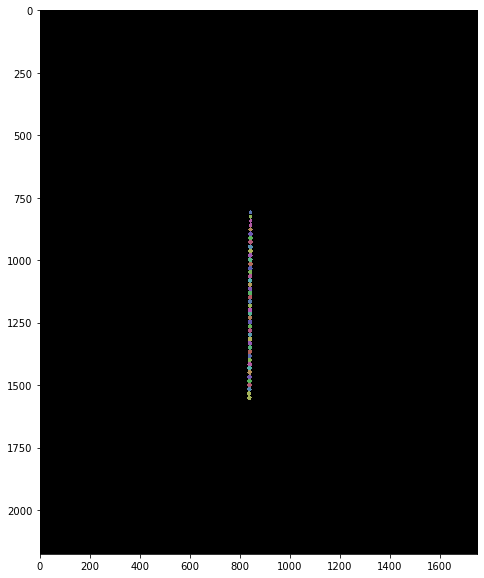

In [19]:
from skimage.measure import label, regionprops, regionprops_table

img = tcal[idx,:,:]
distance = ndi.distance_transform_edt(img)

h=2
localmax = h_maxima(distance,h)
rdmap    = distance.max()-distance
labels   = label(localmax)
ws1 = watershed(min_impose(rdmap,labels),labels,mask=img)
fig,ax=plt.subplots(1,1,figsize=(10,10))
ax.imshow(ws1,interpolation='None',cmap=goldenCM(labels.max()))

### Figuring out beads

In [20]:
rp = regionprops_table(ws1,properties=('area','centroid'))
cog=np.zeros([rp['centroid-0'].shape[0],2])
cog[:,0]=rp['centroid-0']
cog[:,1]=rp['centroid-1']

In [21]:
def findBeadsWS(img, selem= disk(3),h=2) :
    distance = ndi.distance_transform_edt(erode(img,selem))

    localmax = h_maxima(distance,h)
    rdmap    = distance.max()-distance
    labels   = label(localmax)
    ws1 = watershed(min_impose(rdmap,labels),labels,mask=img)
    
    rp = regionprops_table(ws1,properties=('area','centroid'))
       
    cog=np.zeros([rp['centroid-0'].shape[0],2])
    cog[:,0]=rp['centroid-0']
    cog[:,1]=rp['centroid-1']
    return cog

def findBeads(img, selem, c = 1.96) :
    eimg = erode(img,selem)
     
    labels = label(eimg)
    ll = {}
    for i in np.arange(0, labels.max()+1):
        a = np.sum(labels==i)
        if (a<np.prod(img.shape)/2) :
            ll[i]=a
    m = np.mean(list(ll.values()))
    s = np.std(list(ll.values()))
    
    cog=[]
    for lbl in ll :
        selection=np.argwhere(labels==lbl)
        if ((len(selection)<m+c*s) and (m-c*s<len(selection))):
            cog.append(selection.mean(axis=0))
       
    cog=np.asarray(cog)
    return cog


def buildBeadList(img,selem=disk(12),c=1.96) :
    beadlist = []

    for idx in np.arange(0, img.shape[2]) :
        cog=findBeadsWS(img[:,:,idx],selem,c)
        beadlist.append(cog)

    return beadlist

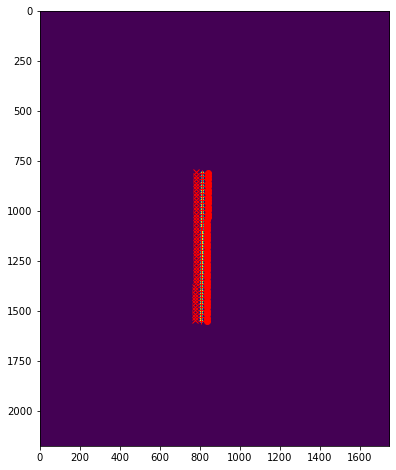

In [22]:
idx=11
c=4
cog=findBeadsWS(tcal[idx,:,:])

plt.figure(figsize=[12,8])
plt.imshow(tcal[idx,:,:])

plt.plot(cog[:,1]-1,cog[:,0]-1,'r+')

cog1=findBeadsWS(tcal[idx+1,:,:])
plt.plot(cog1[:,1]-1,cog1[:,0]-1,'rx')

cog2=findBeadsWS(tcal[idx-1,:,:])
plt.plot(cog2[:,1]-1,cog2[:,0]-1,'ro')

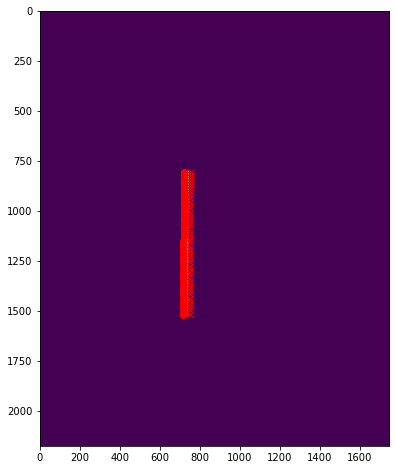

In [23]:
idx=21
c=4
cog=findBeadsWS(tcal[idx,:,:])

plt.figure(figsize=[12,8])
plt.imshow(tcal[idx,:,:])

plt.plot(cog[:,1]-1,cog[:,0]-1,'r+')

cog1=findBeadsWS(tcal[idx+1,:,:])
plt.plot(cog1[:,1]-1,cog1[:,0]-1,'rx')

cog2=findBeadsWS(tcal[idx-1,:,:])
plt.plot(cog2[:,1]-1,cog2[:,0]-1,'ro')

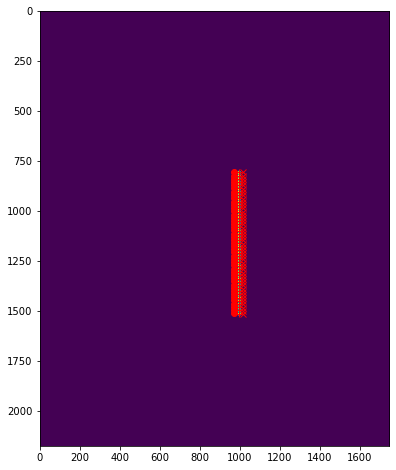

In [24]:
idx=31
c=k
cog=findBeadsWS(tcal[idx,:,:])

plt.figure(figsize=[12,8])
plt.imshow(tcal[idx,:,:])

plt.plot(cog[:,1]-1,cog[:,0]-1,'r+')

cog1=findBeadsWS(tcal[idx+1,:,:])
plt.plot(cog1[:,1]-1,cog1[:,0]-1,'rx')

cog2=findBeadsWS(tcal[idx-1,:,:])
plt.plot(cog2[:,1]-1,cog2[:,0]-1,'ro')

### Plotting Corresponding ellipses

In [25]:
def medianDistance(cog) :
    return np.median(np.diff(cog[:,0]))

def itemList(cog) :
    d=medianDistance(cog)
    idx=np.floor((cog[:,0]-cog[0,0])/d+0.5).astype(int)
    
    idxList={}
    for (i,c) in zip(idx,cog) :
        idxList[i]=c
        
    return idxList

def pruneEllipse(e) :
    pe = 1
    
def identifyEllipses(img,selem,c) :
    N=img.shape[0]
    ellipses = {}
        
    for proj in tqdm(np.arange(0,N)) :
        cog = findBeads(img[proj,:,:])
        cogIdx = itemList(cog)
        for idx in cogIdx :
            if idx in ellipses :
                ellipses[idx] = np.vstack([ellipses[idx], cogIdx[idx]])
            else :
                ellipses[idx] = cogIdx[idx]
        
    
    return ellipses

def identifyEllipses2(img,selem) :
    N=img.shape[0]
    ellipses = []
    params=[]
    cog_allbeads=[]    
    beads = []
    for proj in tqdm(np.arange(0,N)) :
        cog = findBeadsWS(img[proj,:,:])
        beads.append(cog)


    for idx in range(len(min(beads,key=len))):
        ellipse = []
        for p in range(N) :
            ellipse.append(beads[p][idx,:].tolist())
        ellipses.append(np.array(ellipse))
        ell = EllipseModel()
        a_ellipse = np.array(ellipse)
        ell.estimate(a_ellipse)
        if ell.params==None:
            continue
        cog_onebead=[]
        for p in range(N) :
            cog_onebead.append(beads[p][idx,:])
        cog_allbeads.append(cog_onebead)
        xc, yc, a, b, theta = ell.params
        print("ID Number = ", idx)
        print("center = ",  (xc, yc))
        print("angle of rotation = ",  theta)
        print("axes = ", (a,b))
        x=a_ellipse[:,0]
        y=a_ellipse[:,1]
        fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)
        axs[0].scatter(x, y)

        axs[1].scatter(x, y)
        axs[1].scatter(xc, yc, color='red', s=100)
#         axs[1].set_xlim(x.min(), x.max())
#         axs[1].set_ylim(y.min(), y.max())

        ell_patch = Ellipse((xc, yc), 2*a, 2*b, theta*180/np.pi, edgecolor='red', facecolor='none')

        axs[1].add_patch(ell_patch)
        plt.show()
        params.append([xc,yc,a,b,theta])
    return params,cog_allbeads

  0%|          | 0/34 [00:00<?, ?it/s]

ID Number =  0
center =  (808.265387277399, 876.4466056272072)
angle of rotation =  -0.0027314773404559915
axes =  (2.58959564144592, 125.45129448675159)


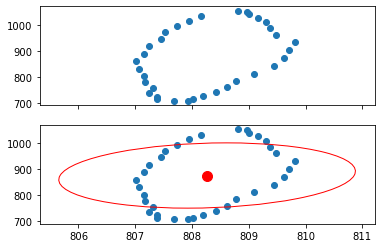

ID Number =  2
center =  (841.7421940396044, 880.3222707856278)
angle of rotation =  -0.004295536210344106
axes =  (2.7548357107722796, 144.86029420768128)


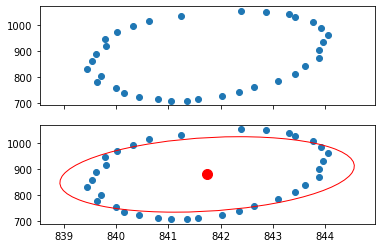

ID Number =  3
center =  (858.219730435153, 878.1751508278351)
angle of rotation =  -0.003879372265430972
axes =  (3.0876680109101837, 151.61253736324)


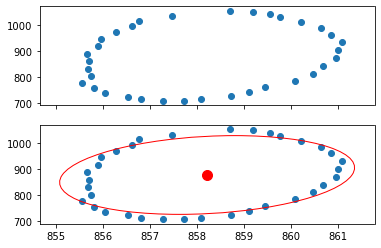

ID Number =  4
center =  (874.4250557042624, 877.6308700086178)
angle of rotation =  -0.004006121567925284
axes =  (3.5059736306573157, 152.4960735854777)


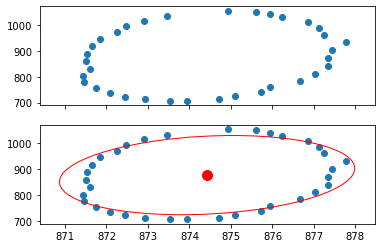

ID Number =  6
center =  (908.0351913218045, 879.0719525005536)
angle of rotation =  -0.003785985017764168
axes =  (4.2342987227478845, 162.34439342913169)


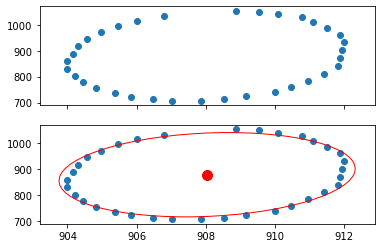

ID Number =  7
center =  (925.0650770577388, 879.5191186255266)
angle of rotation =  -0.0035819603494451763
axes =  (4.473134451205817, 171.38661502803157)


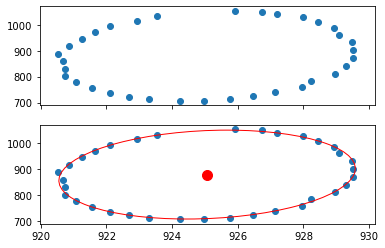

ID Number =  8
center =  (941.9748645627559, 880.475698181875)
angle of rotation =  -0.0037174608355221676
axes =  (4.838252810128446, 174.86656983680956)


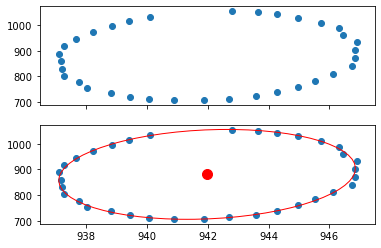

ID Number =  9
center =  (959.0082385863079, 881.410181192061)
angle of rotation =  -0.003575255895414295
axes =  (5.375318480292122, 173.24390478927205)


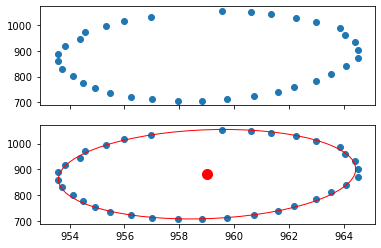

ID Number =  10
center =  (975.7580414239467, 879.8719634393975)
angle of rotation =  -0.003623728805904691
axes =  (5.907540155616601, 171.6104960625088)


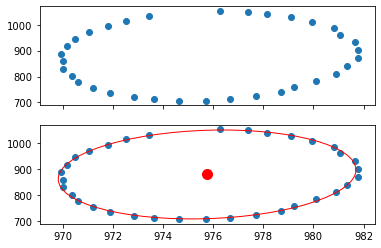

ID Number =  11
center =  (992.5736317422642, 879.2700617271213)
angle of rotation =  -0.00352605319621724
axes =  (6.24734064804482, 173.73459013872085)


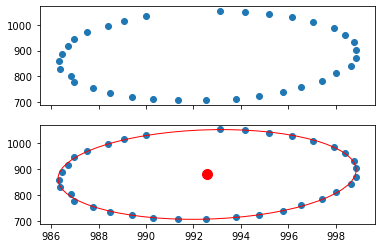

ID Number =  12
center =  (1009.4495830290701, 879.8897096654414)
angle of rotation =  -0.003491898063759035
axes =  (6.746144130217693, 172.67687750633684)


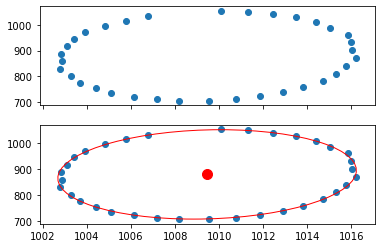

ID Number =  13
center =  (1026.216423980401, 878.9473256309733)
angle of rotation =  -0.00407676418673967
axes =  (7.1580013444309225, 173.76864982184154)


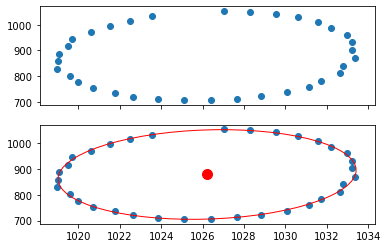

ID Number =  14
center =  (1041.5624534294102, 880.2164028151948)
angle of rotation =  -0.0039892496416031875
axes =  (7.600404319344958, 174.30768398833447)


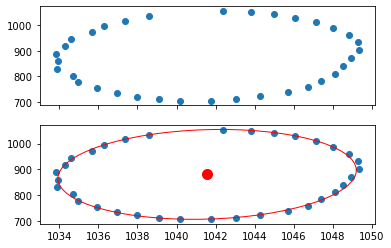

ID Number =  15
center =  (1057.1838115134428, 880.2178057579239)
angle of rotation =  -0.003491086476358758
axes =  (8.021519823180636, 174.44636905026383)


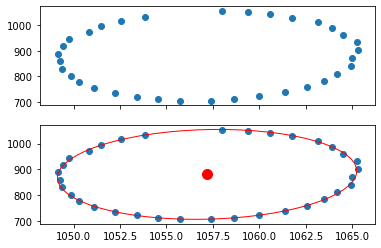

ID Number =  16
center =  (1073.4563303425944, 879.6988707471094)
angle of rotation =  -0.003405308980781915
axes =  (8.466835634697905, 174.53862960454762)


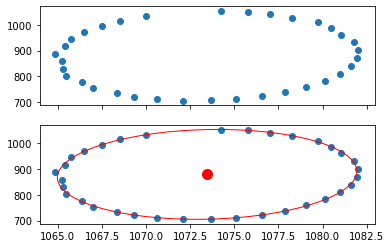

ID Number =  17
center =  (1089.9467430571606, 879.9480314293355)
angle of rotation =  -0.003247965236114505
axes =  (8.940293036947395, 174.39714064276706)


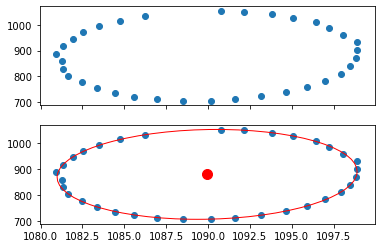

ID Number =  18
center =  (1106.3905135105053, 878.7440293485799)
angle of rotation =  -0.003380184628743166
axes =  (9.412965580040384, 174.4495874435138)


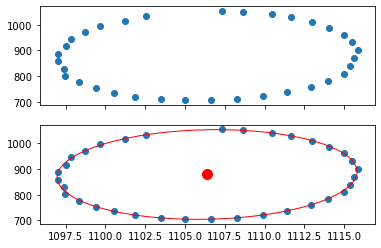

ID Number =  19
center =  (1122.565825816198, 878.9754677346468)
angle of rotation =  -0.003657613656494193
axes =  (9.842270804589253, 174.50474150238642)


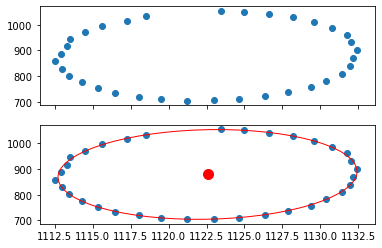

ID Number =  20
center =  (1138.9152330475442, 879.5560489207516)
angle of rotation =  -0.003825648961186655
axes =  (10.266809487925949, 174.89941875624584)


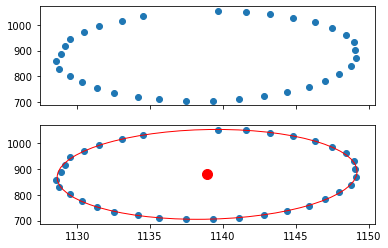

ID Number =  21
center =  (1155.3621011655966, 879.3526866129079)
angle of rotation =  -0.003197005763768548
axes =  (10.776965709903, 174.7378523586076)


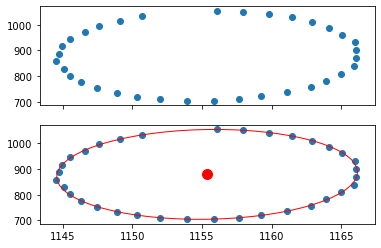

ID Number =  22
center =  (1171.9757320383465, 879.0506866065897)
angle of rotation =  -0.003556201180214893
axes =  (11.2092442012299, 174.72582783363293)


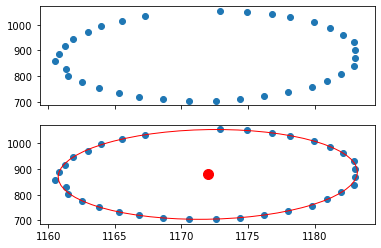

ID Number =  23
center =  (1188.314278730855, 878.0079587588818)
angle of rotation =  -0.0038608379766232755
axes =  (11.642973885576518, 174.91313348583077)


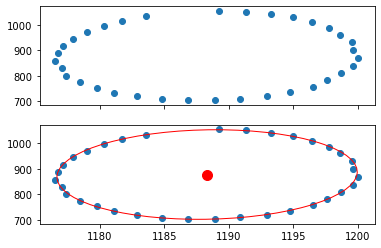

ID Number =  24
center =  (1203.5343116826966, 878.6977004164844)
angle of rotation =  -0.0036978449159592998
axes =  (12.05422724557706, 175.1255665603857)


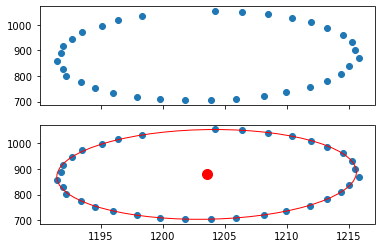

ID Number =  25
center =  (1219.1994398115883, 878.8662631401367)
angle of rotation =  -0.003732789388724881
axes =  (12.536054668256892, 175.04518362455627)


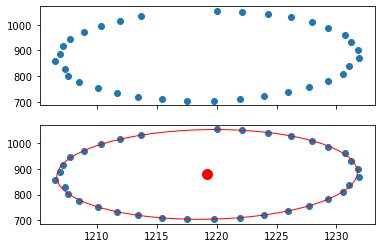

ID Number =  26
center =  (1235.6425548395782, 879.1730611513058)
angle of rotation =  -0.003747230326685785
axes =  (13.000843250425763, 175.21032892449176)


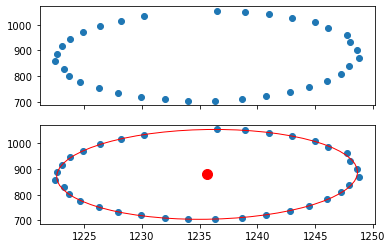

ID Number =  27
center =  (1252.2709407911861, 879.355855079028)
angle of rotation =  -0.003572034784116693
axes =  (13.38903549987684, 175.88776360412476)


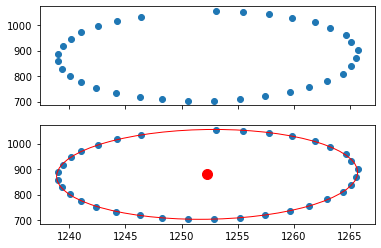

ID Number =  28
center =  (1268.835878919642, 879.1013311760773)
angle of rotation =  -0.003437922897687872
axes =  (13.871025702480376, 175.72124575514297)


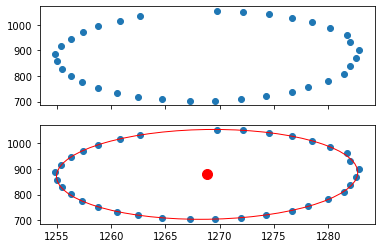

ID Number =  29
center =  (1285.1981640120666, 878.7564409910706)
angle of rotation =  -0.003605323724519163
axes =  (14.394165076889932, 175.1843373153122)


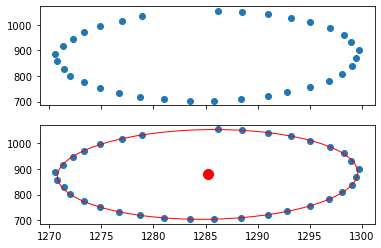

ID Number =  30
center =  (1301.6772049711233, 878.5499071799344)
angle of rotation =  -0.0038698812474137977
axes =  (14.838111748733754, 175.68486740699768)


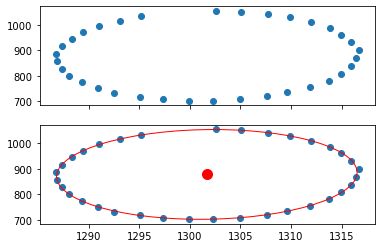

ID Number =  31
center =  (1318.403831453518, 878.5233654919509)
angle of rotation =  -0.0035056755082270193
axes =  (15.33090858501091, 175.81574628481957)


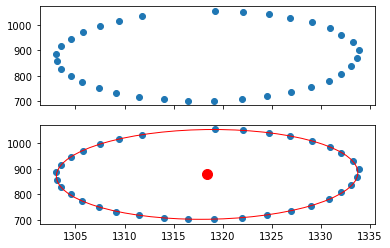

ID Number =  32
center =  (1334.78780883037, 878.6475688449835)
angle of rotation =  -0.0035252923954378246
axes =  (15.787874998583847, 176.15617092770697)


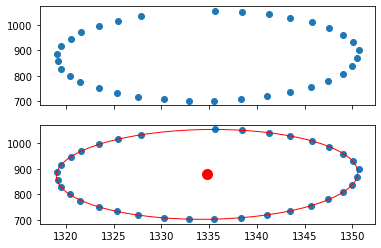

ID Number =  33
center =  (1351.2295043541953, 878.4260413099711)
angle of rotation =  -0.003736317355848858
axes =  (16.250359313648392, 175.84264035735237)


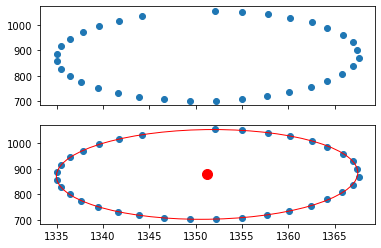

ID Number =  34
center =  (1367.6059109201342, 878.3283052375992)
angle of rotation =  -0.003670227657354039
axes =  (16.716475768080105, 176.182974741324)


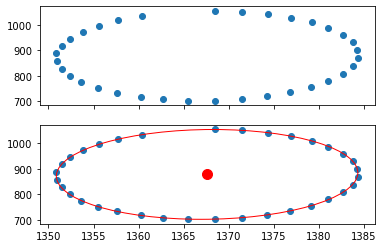

ID Number =  35
center =  (1383.9880069370458, 878.5466633883957)
angle of rotation =  -0.0032614459683938946
axes =  (17.164791545549754, 176.8343754959746)


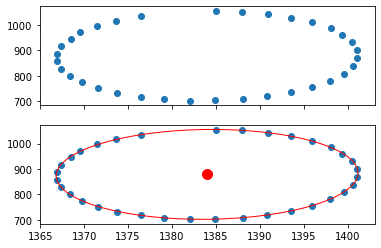

ID Number =  36
center =  (1400.2861903778044, 878.1247753197413)
angle of rotation =  -0.003567132353375394
axes =  (17.63595309406943, 176.75932132667208)


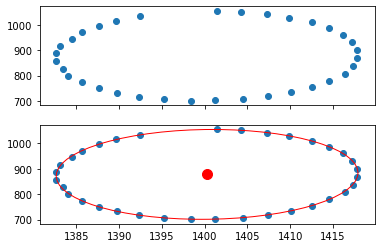

ID Number =  37
center =  (1415.8757991198247, 878.4516864763392)
angle of rotation =  -0.00363289209889024
axes =  (18.059866101998296, 176.14754180311382)


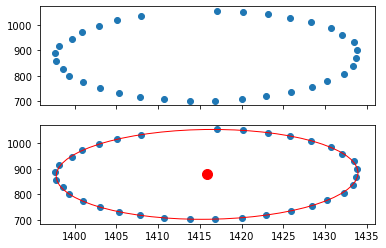

ID Number =  38
center =  (1431.562527854383, 878.2293857406967)
angle of rotation =  -0.003211089827562734
axes =  (18.43051884166105, 177.01447524498005)


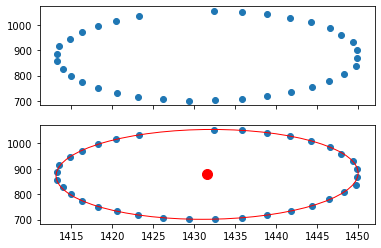

ID Number =  39
center =  (1448.1932413648856, 878.1241816699869)
angle of rotation =  -0.002915928123110344
axes =  (18.94568410044787, 176.98413701852067)


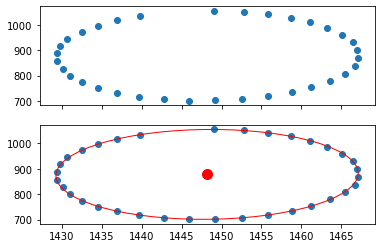

ID Number =  40
center =  (1464.7902710416295, 877.8720193398656)
angle of rotation =  -0.003529624704117597
axes =  (19.44469970122066, 177.1590848419464)


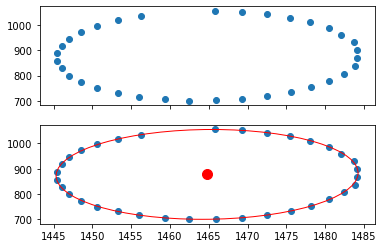

ID Number =  41
center =  (1481.3943952667069, 877.8949717402453)
angle of rotation =  -0.0036211677735365844
axes =  (19.897029860265274, 177.204284727683)


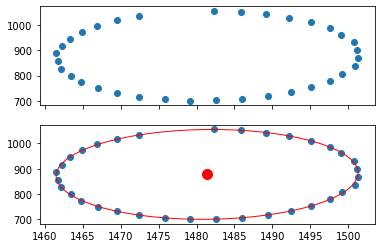

ID Number =  42
center =  (1498.003220723937, 877.873394481787)
angle of rotation =  -0.003205463148578567
axes =  (20.36747040884591, 177.20270976818315)


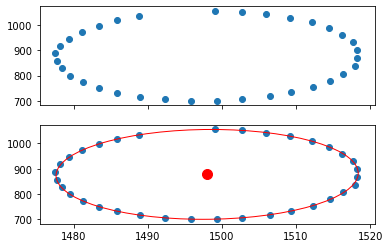

ID Number =  43
center =  (1514.3091093646956, 877.730556780267)
angle of rotation =  -0.0031264869610897464
axes =  (20.96481600104129, 178.156228645981)


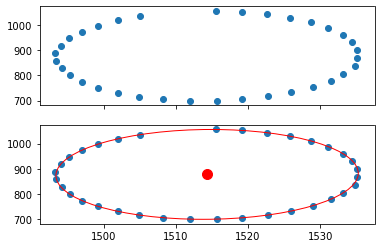

ID Number =  44
center =  (1530.6233752083024, 877.8173230972798)
angle of rotation =  -0.0033911865685793707
axes =  (21.259668236078255, 177.7558386351266)


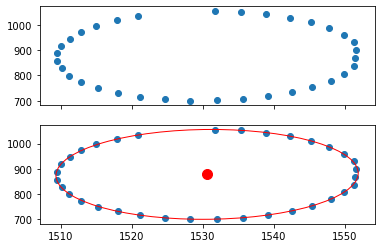

In [26]:
[e2,cog_allbeads]=identifyEllipses2(tcal,selem=disk(2))

In [27]:
len(e2) , len(cog_allbeads)

(43, 43)

In [28]:
#Removing the first 10 ellipse and beads entries to remove the outliers
n=10
del e2[0:3]
#del e2[24:]

In [29]:
del cog_allbeads[0:3]
#del cog_allbeads[24:]

In [30]:
len(e2) , len(cog_allbeads)

(40, 40)

### Estimating COR and tilt about the center

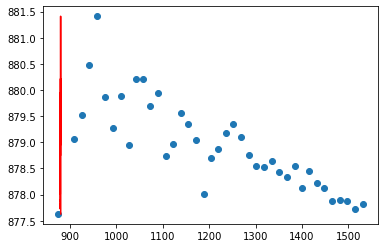

In [31]:
x_centres=[]
y_centres=[]
for i in range(len(e2)):
    x_centres.append(e2[i][1])
    y_centres.append(e2[i][0])
theta=np.polyfit(y_centres, x_centres, 1)

plt.scatter(y_centres,x_centres)
plt.plot(theta[1]+theta[0]*np.array(y_centres), x_centres, 'r')
plt.show()

In [32]:
print("The parameters of the COR obtained are as follows:",(theta[0], theta[1]))

The parameters of the COR obtained are as follows: (-0.0031261237353048437, 882.7113775389515)


#### Final value of COR can be obtained by subtractin the projection value taken 

In [33]:
tilt = np.arctan(theta[0])*180/np.pi
print("The tilt of the center of rotation is in degrees: ", tilt)

The tilt of the center of rotation is in degrees:  -0.17911311280026299


### Estimating Piercing Point

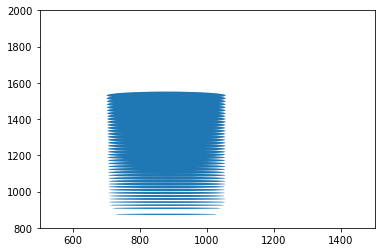

In [34]:
fig, ax = plt.subplots()

for idx in range(len(e2)):
    ellipse = Ellipse((e2[idx][1], e2[idx][0]), e2[idx][3]*2, e2[idx][2]*2, e2[idx][4])
    ax.add_artist(ellipse)

ax.set_xlim(500, 1500)
ax.set_ylim(800, 2000)

plt.show()

In [35]:
radius=[]
height=[]
for i in range(len(e2)):
    radius.append(e2[i][2])
    height.append(e2[i][0])

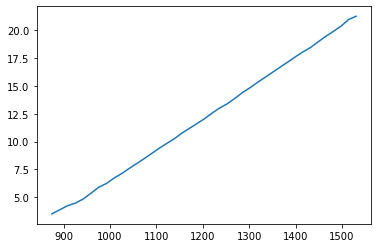

In [36]:
plt.plot(height,radius)

In [37]:
i = np.argmin(radius)
x_min = height[i]
y_min = e2[i][1]
print(x_min, y_min)

874.4250557042624 877.6308700086178


In [38]:
vpiercing= y_min
hpiercing= x_min

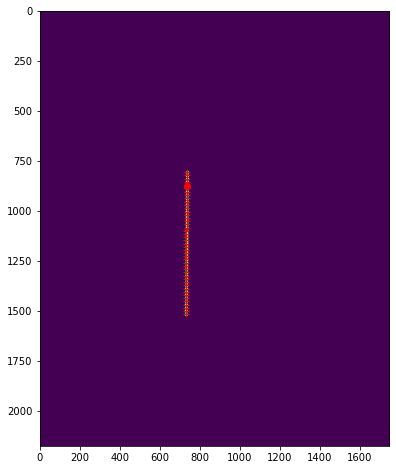

In [39]:
idx=21
c=2.5
cog=findBeadsWS(tcal[idx,:,:])

plt.figure(figsize=[12,8])
plt.imshow(tcal[idx,:,:])

plt.plot(cog[:,1]-1,cog[:,0]-1,'r+')
plt.plot(cog[10,1]-1,vpiercing,'ro')

### Estimating SOD and SDD

In [40]:
def estDistances(h,ha,hb,R) :
    H = np.array([[1,-h/ha], [1,-h/hb]])
    y = np.array([-R,R])
        
    est=np.linalg.solve(H,y)
    
    return est

In [41]:
pixelSize = 0.139
R = 10
c0=itemList(findBeadsWS(tcal[0,:,:]))
sod = []
sdd = [] 
for idx in range(np.array(e2).shape[0]) :
    ha=(e2[idx][0]-e2[idx][2]-vpiercing) * pixelSize
    hb=(e2[idx][0]+e2[idx][2]-vpiercing) * pixelSize
    h=0
    if idx in c0 :
        h = (c0[idx][0]-vpiercing)*pixelSize
    est_sod= (hb+ha)*R/(hb-ha)
    est_sdd= ((est_sod-R)*hb)/h
    sod.append(np.abs(est_sod))
    sdd.append(np.abs(est_sdd))
    print("h: {0:0.3f}, S0D: {1:0.2f}, SDD: {2:0.2f}, magn: {3:0.2f}".format(h,est_sod, est_sdd,est_sdd/est_sod))

sod = np.mean(sod)
sdd = np.mean(sdd)
            
print("Mean SOD= ", sod)
print("Mean SDD= ", sdd)
print("Magnification= ", sdd/sod)

h: -9.567, S0D: -9.14, SDD: 0.08, magn: -0.01
h: -7.193, S0D: 71.80, SDD: -41.37, magn: -0.58
h: -4.898, S0D: 106.04, SDD: -141.49, magn: -1.33
h: -2.630, S0D: 132.99, SDD: -449.72, magn: -3.38
h: -0.376, S0D: 151.39, SDD: -4528.65, magn: -29.91
h: 1.993, S0D: 166.10, SDD: 1132.94, magn: 6.82
h: 4.342, S0D: 183.99, SDD: 675.03, magn: 3.67
h: 6.713, S0D: 195.40, SDD: 531.93, magn: 2.72
h: 9.060, S0D: 207.58, SDD: 472.11, magn: 2.27
h: 11.388, S0D: 215.69, SDD: 430.66, magn: 2.00
h: 13.709, S0D: 223.84, SDD: 406.69, magn: 1.82
h: 16.055, S0D: 231.29, SDD: 391.39, magn: 1.69
h: 18.412, S0D: 237.48, SDD: 379.99, magn: 1.60
h: 20.764, S0D: 243.03, SDD: 371.54, magn: 1.53
h: 22.902, S0D: 248.86, SDD: 369.36, magn: 1.48
h: 25.073, S0D: 254.49, SDD: 368.07, magn: 1.45
h: 27.330, S0D: 257.71, SDD: 363.47, magn: 1.41
h: 29.623, S0D: 262.59, SDD: 362.15, magn: 1.38
h: 31.931, S0D: 266.84, SDD: 360.38, magn: 1.35
h: 34.171, S0D: 270.36, SDD: 357.93, magn: 1.32
h: 36.423, S0D: 272.47, SDD: 354.69, 

## Appendix - Extra Code snippets 

In [94]:
pixelSize = 0.139
R = 10
c0=itemList(findBeadsWS(tcal[0,:,:]))
sod = []
sdd = [] 


for idx in range(np.array(e2).shape[0]) :
    ha=(e2[idx][1]-e2[idx][2]-hpiercing) * pixelSize
    hb=(e2[idx][1]+e2[idx][2]-hpiercing) * pixelSize
    if idx in c0 :
        h = (c0[idx][0]-hpiercing)*pixelSize
        est = estDistances(h,ha,hb,R)
        sod.append(np.abs(est[0]))
        sdd.append(np.abs(est[1]))
        print("h: {0:0.3f}, S0D: {1:0.2f}, SDD: {2:0.2f}, magn: {3:0.2f}".format(h,est[0], est[1], est[1]/est[0]))

sod = np.mean(sod)
sdd = np.mean(sdd)
            
print("Mean SOD= ", sod)
print("Mean SDD= ", sdd)
print("Magnification= ", sdd/sod)

h: -199.867, S0D: -7.89, SDD: 1.80, magn: -0.23
h: -191.650, S0D: -7.91, SDD: 1.86, magn: -0.24
h: -182.066, S0D: -7.88, SDD: 2.00, magn: -0.25
h: -172.144, S0D: -7.89, SDD: 2.12, magn: -0.27
h: -162.393, S0D: -7.87, SDD: 2.28, magn: -0.29
h: -152.724, S0D: -7.87, SDD: 2.43, magn: -0.31
h: -142.959, S0D: -7.84, SDD: 2.64, magn: -0.34
h: -133.419, S0D: -7.84, SDD: 2.83, magn: -0.36
h: -123.974, S0D: -7.84, SDD: 3.06, magn: -0.39
h: -114.654, S0D: -7.87, SDD: 3.26, magn: -0.41
h: -104.871, S0D: -7.82, SDD: 3.68, magn: -0.47
h: -95.156, S0D: -34.25, SDD: -25.48, magn: 0.74
h: -85.333, S0D: -8.23, SDD: 3.59, magn: -0.44
h: -75.628, S0D: -8.24, SDD: 4.02, magn: -0.49
h: -65.864, S0D: -8.24, SDD: 4.65, magn: -0.56
h: -56.201, S0D: -8.21, SDD: 5.55, magn: -0.68
h: -46.491, S0D: -8.17, SDD: 6.86, magn: -0.84
h: -36.755, S0D: -8.16, SDD: 8.75, magn: -1.07
h: -26.997, S0D: -8.17, SDD: 11.85, magn: -1.45
h: -18.154, S0D: -26.76, SDD: -100.24, magn: 3.75
Mean SOD=  10.248284572287917
Mean SDD=  9.

In [ ]:
np.median(np.diff(cog[:,0]))

In [ ]:
cog=findBeadsWS(tcal[:,:,0])
d=medianDistance(cog)
idx=np.floor((cog[:,0]-cog[0,0])/d+0.5).astype(int)
    
idxList={}
for (i,c) in zip(idx,cog) :
    idxList[i]=c
    
print(idxList)

In [52]:
cog

array([[ 807.23857868,  737.20304569],
       [ 823.70149254,  736.98507463],
       [ 840.14948454,  737.25257732],
       [ 856.04950495,  736.62376238],
       [ 872.0776699 ,  736.5631068 ],
       [ 888.84541063,  736.57971014],
       [ 905.37931034,  736.46305419],
       [ 922.09615385,  736.29326923],
       [ 938.81339713,  736.25358852],
       [ 955.46464646,  735.94444444],
       [ 971.89423077,  735.96153846],
       [ 988.48275862,  735.71921182],
       [1005.1047619 ,  735.6047619 ],
       [1021.79      ,  735.45      ],
       [1036.93650794,  735.48148148],
       [1052.24870466,  735.20207254],
       [1068.33168317,  735.23762376],
       [1084.45      ,  735.09      ],
       [1100.50980392,  734.77941176],
       [1116.43902439,  734.67317073],
       [1132.5       ,  734.77227723],
       [1148.92890995,  734.46445498],
       [1165.27941176,  734.43627451],
       [1181.05524862,  734.29834254],
       [1195.9516129 ,  734.29032258],
       [1211.64356436,  7

In [61]:
distance = np.sqrt((cog[0][0]-cog[1][0])**2 + (cog[0][1]-cog[1][1])**2)
radius = distance/2
print("distance= ", distance)
print("magnification= ", distance/0.139)

distance=  16.464356776046333
magnification=  118.4486098996139
